In [ ]:
import classes
import functies
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

In [60]:
def get_data_from_folder(mypath):
    """
    @in: het adres van een folder waaruit data getrokken wordt
    @out:   een lijst met namen van de files
            een datalijst: datalijst[experiment] = np.array([ [tijden (sec)],  [spannning CH1 (V)], [spanning CH2 (V)] ])
    
    """
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
    datalijst = []

    for filenaam in onlyfiles:
        adres = mypath+'/'+filenaam
        file = open(adres, 'rt')
        data = file.read()
        file.close()
        data = data.replace(',','.') #ga naar deftige decimaalseparators
        inhoud = data.split('s	V	V')[1].split('\n')
        inhoudlijst = []
        #steek het in een lijst
        for regel in inhoud:
            if regel != '':
                lijst = regel.split('	')
                lijst = [float(elem) for elem in lijst]
                inhoudlijst.append(lijst.copy())
        inhoudlijst = np.array(inhoudlijst).T
        datalijst.append(inhoudlijst.copy())
    return onlyfiles, datalijst


def blokgolf(x, parameters): #een blokgolf met grootte G, frequentie f en offset x0, rond evenwichtspunt E
    f, G,  x0, E = parameters
    a = 2/f
    out = []
    for xval in x:
        xi = xval - x0
        periode = 1
        while not (periode-1)*a <= xi < periode*a:
            if xi < periode*a:
                periode -= 1
            else:
                periode += 1
        out.append(E + G*(-1)**periode)
    return np.array(out)

def sinus(x, parameters):
    A, k, phi, C = parameters
    return A*np.sin(k*x+phi)+C

def fit_blokgolf(xvals, yvals, invalslist, limieten = None):
    def invals(x,y):
        return invalslist
    fig, ax = plt.subplots(1,1,figsize = (15,5))
    Xval = np.linspace(0,5,1000)
    print('invals',invalslist)
    ax.errorbar(xvals, yvals, yerr = np.full(np.shape(yvals), 0.1), linestyle = '',label = 'data', marker = '')
    ax.plot(Xval, blokgolf(Xval, invalslist), label = 'invals')
    plt.tight_layout()
    ax.legend()
    plt.show()
    print('broer fit gewoon')
    outp = functies.fit(["f",'G',"x_0",'E'], blokgolf, invals, xvals, yvals, initial_range=limieten, y_err = np.full(np.shape(yvals), 5), detailed_logs = False, minimizemethod='fuck you')
    parameterwaarden = [param[0] for param in outp]
    fig, ax = plt.subplots(1,1,)
    Xval = np.linspace(0,5,1000)
    ax.scatter(xvals, yvals, linestyle = '',label = 'data')
    ax.plot(Xval, blokgolf(Xval, parameterwaarden), label = 'model')
    plt.tight_layout()
    ax.legend()
    plt.show()

    return outp

def fit_sinus(xvals, yvals, yerr, freqgok = 1, plotting = False, detailed_logs = False):
    #bepaal initiele waarden
    maximum = max(yvals)
    minimum = min(yvals)
    amplitude = (maximum - minimum)/2
    C = (maximum + minimum)/2
    if yvals[0] <= yvals[1]:
        if -1 <= (yvals[0] - C)/amplitude <= 1:
            phi = np.arcsin( (yvals[0] - C)/amplitude )
        else:
            phi = np.arcsin(yvals[0]/amplitude )
            C = 0
    else:
        if -1 <= (yvals[0] - C)/amplitude <= 1:
            phi = np.pi - np.arcsin( (yvals[0] - C)/amplitude )
        else:
            phi = np.pi - np.arcsin( yvals[0]/amplitude )
            C = 0

    def invals(x,y):
        return [amplitude, 2*np.pi*freqgok, phi, C]
    outp = functies.fit(['A','k','phi','C'], sinus, invals, xvals, yvals, y_err = yerr, detailed_logs=detailed_logs, fuck_CPU = True)
    plotparams = [elem[0] for elem in outp]
    if plotting:
        fig, ax = plt.subplots(1,1)
        ax.errorbar(xvals, yvals, yerr=yerr, linestyle = '', label = 'data')
        T = np.linspace(min(xvals),max(xvals),1000)
        ax.plot(T, sinus(T,plotparams),label = 'model')
        #ax.plot(T, sinus(T, invals(0,0)), label = 'invals')
        ax.legend()
        ax.set_xlabel('tijd (s)')
        ax.set_ylabel('spanning (mV of zo)')
        plt.tight_layout()
        plt.show()
    return outp

def fix_enkelzijdige_fout(outp):
    """
    @in: de output van een functies.fit
    @out: hetzelfde maar de fouten zijn geen tuples meer
    """
    for indx in range(len(outp)):
        if type(outp[indx][1]) == tuple:
            outp[indx][1] = (abs(outp[indx][1][0])+abs(outp[indx][1][1]))/2
    return outp

In [ ]:
mypath = "RLC proef/RC"
namen, datalijst = get_data_from_folder(mypath)
freqgoks = [4.2,2]
verschuivingen = [0, 0]
limietlijst = [[(1,6), (5,7), (0,2),(-1,1)], None]
for indx in range(len(namen)):
    top = max(datalijst[indx][1])
    bot = min(datalijst[indx][1])
    invalslist = [freqgoks[indx], (top-bot)/2, verschuivingen[indx], (top+bot)/2]
    fit_blokgolf(datalijst[indx][0], datalijst[indx][1], invalslist, limieten = limietlijst[indx])

input bij freq 0.12
[[5.807299859679454, 5.816985639679454], [0.6002946987515079, 0.6005927227515078], [3.0500399183052282, 3.051828062305228], [0.5049365750956407, 0.5119401390956407]]
A heeft als waarde: 5.8121 + 0.0049174 - 0.0047684 met 68% betrouwbaarheidsinterval: [5.8073, 5.817] 
k heeft als waarde: 0.60044 + 0.00014901 - 0.00014901 met 68% betrouwbaarheidsinterval: [0.60029, 0.60059] 
phi heeft als waarde: 3.0509 + 0.00089407 - 0.00089407 met 68% betrouwbaarheidsinterval: [3.05, 3.0518] 
C heeft als waarde: 0.50836 + 0.0035763 - 0.0034273 met 68% betrouwbaarheidsinterval: [0.50494, 0.51194] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 4.5009
output bij freq 0.12
[[0.3453560366075969, 0.35533984060759694], [0.6004704189808823, 0.6028546109808823], [-1.7504795851200436, -1.7230613771200438], [-0.013264136658587, -0.006260572658587002]]
A heeft als waarde: 0.35027 + 0.0050664 - 0.0049174 met 68% betrouwbaarheid

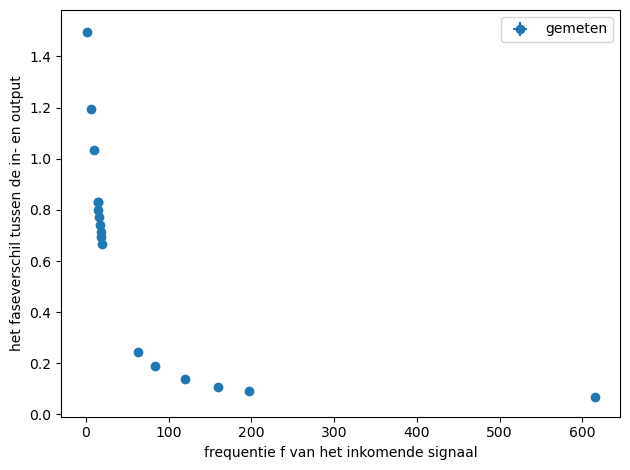

In [67]:
mypath = "RLC proef/CR"
namen, datalijst = get_data_from_folder(mypath)
fase = []
fasefout = []
input_f = [] #frequentie (!= hoekfrequentie) van het inputsignaal
input_f_fout = []
for indx in range(len(datalijst)):
    freqgok = float(namen[indx].replace('CRkring - freq','').replace('.txt',''))
    dataset = datalijst[indx]
    tijden, CH1, CH2 = dataset
    print('input bij freq', freqgok)
    inputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH1, np.full(np.shape(CH1), 0.1),freqgok = freqgok, plotting = False, detailed_logs=False))
    print('output bij freq', freqgok)
    outputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH2, np.full(np.shape(CH2), 0.1), freqgok = freqgok, plotting = False, detailed_logs=False))
    hoek = outputsinus[2][0] - inputsinus[2][0]
    hoekfout = np.sqrt(outputsinus[2][1]**2+inputsinus[2][1]**2)
    while -np.pi > hoek:
        hoek += 2*np.pi
    while hoek > np.pi:
        hoek -= 2*np.pi
    fase.append(hoek)
    fasefout.append(hoekfout)
    input_f.append(inputsinus[1][0]/2*np.pi)
    input_f_fout.append(inputsinus[1][1]/2*np.pi)

#de faseplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal")
ax.set_ylabel('het faseverschil tussen de in- en output')
ax.legend()
plt.tight_layout()
plt.show()